In [32]:
import numpy as np
from scipy.io import loadmat 
from nitime.algorithms import multi_taper_psd
from nitime.utils import dpss_windows
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.formula.api as smf
from pandas import DataFrame as df
from pandas import concat
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlim, ylim, show, imshow, xlabel, ylabel, bar, figure
from matplotlib import rcParams
from numpy import hanning, where, histogram, arange
rcParams['figure.figsize'] = (12,3)


Sinal utilizado na aula: Spikes de neurônio do Núcleo Sub-Talâmico (STN) com 50 trials de uma tarefa motora.
Tarefa motora
Usuário controla um joystick
Aparecem duas mensagens na tela:
Primeiro uma seta indica para onde ele deve mover o joystick (planejamento)
A segunda mensagem é para iniciar o movimento ( movimento)
A duração de cada trial é de 2s (1s para cada mensagem)
Identificar o ritmo dos spikes


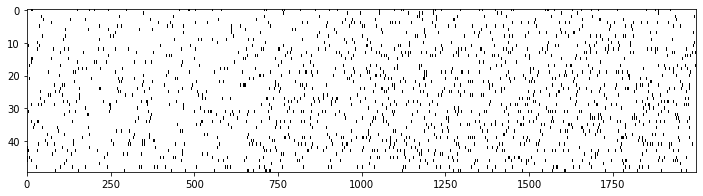

In [33]:
data = loadmat('STN-spikes-1.mat')
t = data['t'][0]  
direction = data['direction'].flatten() 
train = data['train']
imshow(train, aspect='auto',cmap='gray_r')

#Alguma evidência de ritmos ou bursts? Parece que sim, onde tem alguns disparos próximos, mas não aparenta ter um rítmo claro


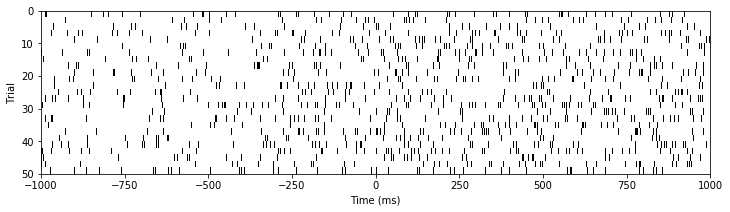

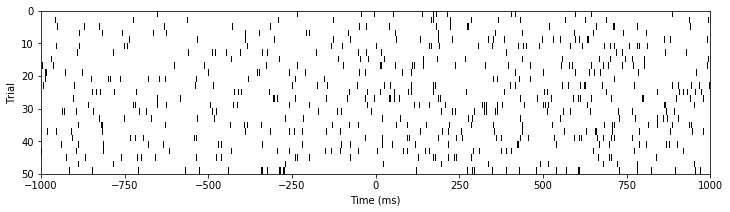

In [73]:
#Análise visual

Ltrials = where(direction==0)
Rtrials = where(direction==1)
imshow(train[Ltrials], aspect = 'auto', cmap='gray_r', extent = (-1000,1000,50,0))
xlabel('Time (ms)')
ylabel('Trial')
show()

imshow(train[Rtrials], aspect = 'auto', cmap='gray_r', extent = (-1000,1000,50,0))
xlabel('Time (ms)')
ylabel('Trial')
show()

# O de cima possui mais disparos, porḿ ainda sem um rítmo muito claro. Há mais disparos durante o planejamento do que o movimento propriamente dito
#Técnica PSTH: Uma das técnicas mais utilizdas nos trabalhos de Nicolelis


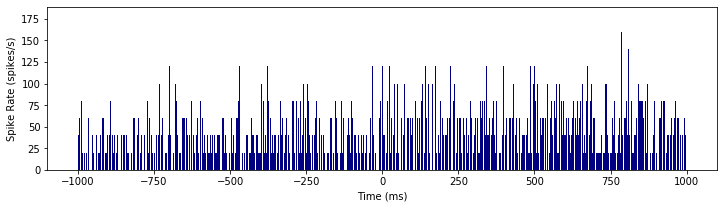

In [69]:
spiketrials, spiketimes = np.where(train)
hist = histogram(spiketimes,2000)[0]/50/1e-3

bar(t, hist, color = "navy") 
xlabel('Time (ms)')
ylabel('Spike Rate (spikes/s)')
show()

# É possível afirmar que há diferenças? Sim, porém não muito evidente - mais difícil de vizualizar os bins (devido ao seu tamanho pequeno) 

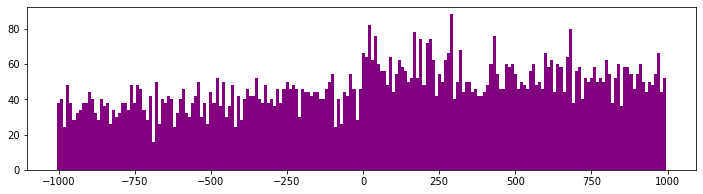

In [68]:
#Aumentando o valor dos bins

PSTH10 = histogram(spiketimes, 200)[0]   
figure()
bar(t[arange(0, 2000, 10)], PSTH10/50/10*1000,width=10, color = "purple")
show()


In [48]:
#Cálculo da taxa de disparos

i_plan = where(t < 0)[0]
i_move = where(t >= 0)[0]
PlanRate = np.mean(train[:, i_plan]) / 1e-3   
MoveRate = np.mean(train[:, i_move]) / 1e-3 
print(PlanRate,MoveRate)


Ltrials = where(direction==0)
Rtrials = where(direction==1)
LRate = np.mean(train[Ltrials, :]) / 1e-3 
RRate = np.mean(train[Rtrials, :]) / 1e-3 
print(LRate, RRate)

38.96 54.96
58.66 35.26


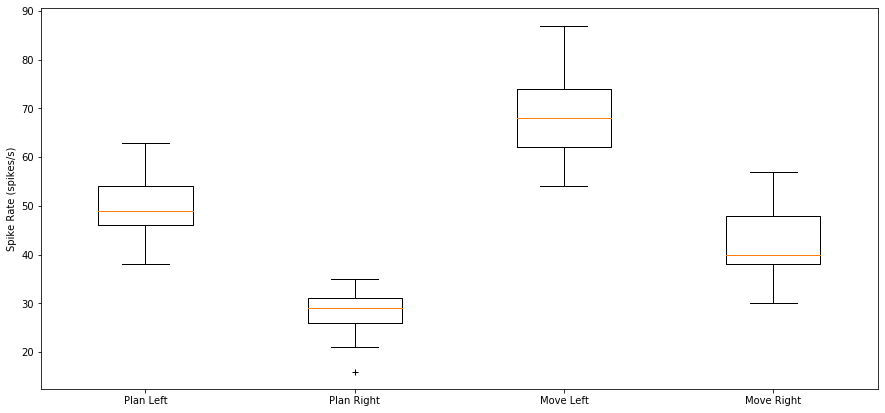

In [56]:
PlanL = np.sum(train[Ltrials][:,i_plan], axis = 1)   
PlanR = np.sum(train[Rtrials][:,i_plan], axis = 1)   
MoveL = np.sum(train[Ltrials][:,i_move], axis = 1)   
MoveR = np.sum(train[Rtrials][:,i_move], axis = 1)   
figure(figsize=(15, 7))

plt.boxplot([PlanL, PlanR, MoveL, MoveR], sym='+',
    labels = ['Plan Left', 'Plan Right', 'Move Left', 'Move Right'])

ylabel('Spike Rate (spikes/s)')
show()


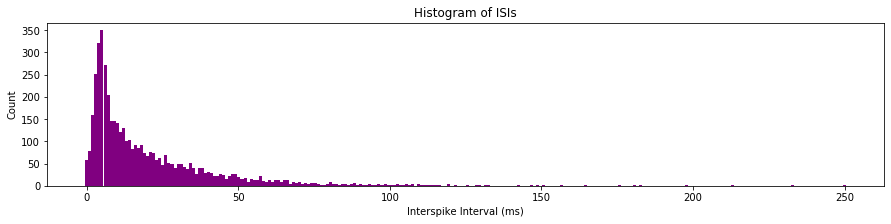

In [74]:
ISIs = np.diff(spiketimes)
ISIs = ISIs[where(ISIs > 0)]
hist = histogram(ISIs, 250)[0]

figure(figsize=(15, 3))
bar(np.linspace(0, 250, 250), hist, width = 1, color = "purple")
xlabel('Interspike Interval (ms)')
ylabel('Count')
plt.title('Histogram of ISIs')
show()

#Este gráfico mostra que a maioria dos spikes estão no começo


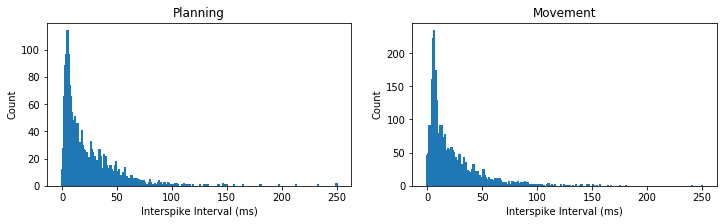

In [83]:
spiketrialsPlan, spiketimesPlan = where(train[:,i_plan] > 0) 
PlanISIs = np.diff(spiketimesPlan)             
PlanISIs = PlanISIs[where(PlanISIs > 0)]
planhist = histogram(PlanISIs, 250)[0]

figure(figsize=(12, 3))
plt.subplot(121)
bar(np.linspace(0, 250, 250), planhist, width = 2)
xlabel('Interspike Interval (ms)')          
ylabel('Count')
plt.title('Planning')
 
spiketrialsMove, spiketimesMove = where(train[:, i_move] > 0) 
MoveISIs = np.diff(spiketimesMove)         
MoveISIs = MoveISIs[where(MoveISIs>0)]  
movehist = histogram(MoveISIs, 250)[0]

plt.subplot(122)
bar(np.linspace(0, 250, 250), movehist, width = 2) 
xlabel('Interspike Interval (ms)')          
ylabel('Count')
plt.title('Movement')
show()


/home/aluno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/aluno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


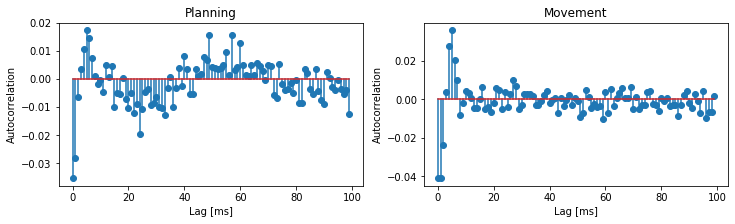

In [103]:
#Auto Co-Relação: ACF - Pega a taxa de disparo em cada bin e calcula no leg do passado: calculo da correlaçao dele com ele mesmo
#Ela fornece uma ideia se tem uma relação entre o passado e...

acf1 = np.zeros((50, 1999))
acf2 = np.zeros((50, 1999))

for k in range(50):
    plan = train[k, i_plan]  
    move = train[k, i_move]  
    corr1 = np.correlate(plan - np.mean(plan), plan - np.mean(plan), 'full')
    acf1[k] = corr1 / np.linalg.norm(plan - np.mean(plan))**2          	
    corr2 = np.correlate(move - np.mean(move), move - np.mean(move), 'full')
    acf2[k] = corr2 / np.linalg.norm(move - np.mean(move))**2          	
    
figure(figsize=(12, 3))
plt.subplot(121)
plt.stem(np.mean(acf1[:,1000:1100], axis = 0))
xlabel('Lag [ms]')
ylabel('Autocorrelation')
plt.title('Planning')

plt.subplot(122)
plt.stem(np.mean(acf2[:,1000:1100], axis = 0))
xlabel('Lag [ms]')
ylabel('Autocorrelation')
plt.title('Movement')
show()


/home/aluno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


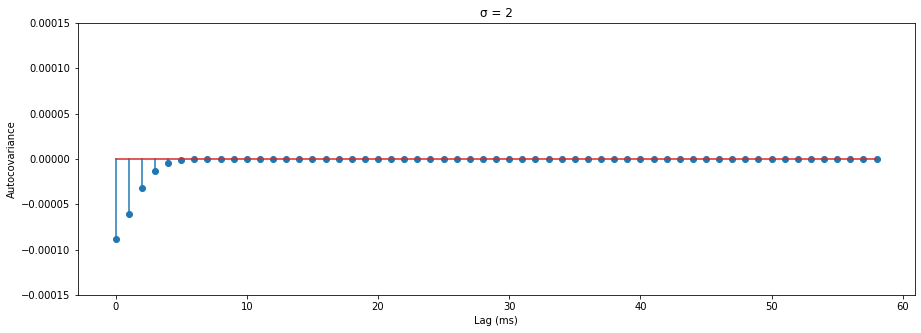

In [109]:
#Análise Espectral

def gaussian(x, mu=0, sig=1):
    return np.exp(-pow(x - mu, 2) / (2 * pow(sig, 2)))


lbda0, alpha, dt = .01, 1e-4, 1e-3

def gamma(lag, sig, lbda0=lbda0, dt=dt, alpha=alpha):
    if lag==0:
        return lbda0 * dt - alpha * gaussian(lag, sig=sig)
    else:
        return -alpha * gaussian(lag, sig=sig)


sig = 2  
autocov = [gamma(lag, sig) for lag in range(1, 60)]

figure(figsize=(15,5))
plt.stem(autocov)
xlabel('Lag (ms)')
ylabel('Autocovariance')
plt.title('σ = {:}'.format(sig))
ylim([-1.5e-4, 1.5e-4])
show()


Text(0.5, 1.0, 'Trial-averaged spectra of spiking data')

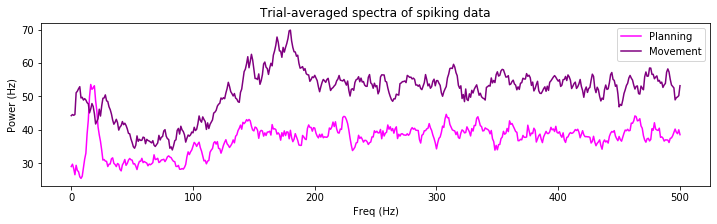

In [116]:
def mt_specpb(data, Fs=1000, NW=4, trial_ave=True):
    
    tapers, _ = dpss_windows(data.shape[-1], NW, 2*NW-1)  
    tapers *= np.sqrt(Fs)  
    dataT = [[trial * t for t in tapers]  
             for trial in data]  
    T = np.fft.rfft(tapers)  
    J = np.fft.rfft(dataT)  

    J -= [T * trial.mean() for trial in data]  
    J *= J.conj()  
    S = J.mean(1).real
    f = np.fft.rfftfreq(data.shape[-1], 1 / Fs)
    if trial_ave : S = S.mean(0)
    return f, S


f, SPlan = mt_specpb(train[:, i_plan])  
_, SMove = mt_specpb(train[:, i_move])  

plot(f, SPlan, label="Planning", color = "fuchsia")  
plot(f, SMove, label="Movement", color = "purple")  
xlabel('Freq (Hz)')  
ylabel('Power (Hz)')
plt.legend()
plt.title('Trial-averaged spectra of spiking data')



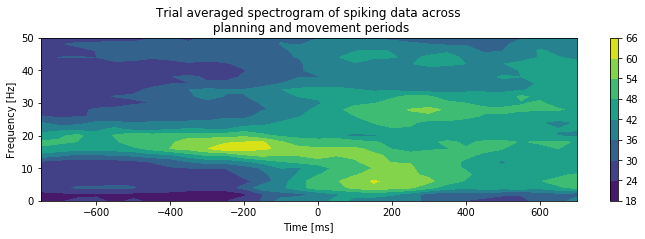

In [147]:
window, step = .5, .05  
fpass = [0, 50]  
Fs = 1000  

window, step = [int(Fs * x) for x in [window, step]]  
starts = range(0, train.shape[-1] - window, step)  
f = mt_specpb(train[:, range(window)], NW=2)[0]  
findx = (f >= fpass[0]) & (f <= fpass[1])  
f = f[findx]  
spectrogram = [mt_specpb(train[:, range(s, s + window)], NW=2)[1][findx] for s in starts]

T = t[starts] + window / 2  

plt.contourf(T, f, np.array(spectrogram).T)  

plt.title('Trial averaged spectrogram of spiking data across\n planning and movement periods')
xlabel('Time [ms]')
ylabel('Frequency [Hz]')
plt.colorbar()
show()



In [121]:
nTrial, nTime = train.shape 
IMove = np.tile(t >= 0, nTrial)  
spikes = train.flatten()  
glmdata = df({'IMove': IMove, 'spikes': spikes})  
M1 = smf.glm('spikes ~ IMove', 
         	data=glmdata, family=sm.families.Poisson()  
        	).fit()  
M1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18990.
Date:                Tue, 26 Nov 2019   Deviance:                       28588.
Time:                        09:42:04   Pearson chi2:                 9.53e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.2452      0.023   -143.232      0.000      -3.290      -3.201
IMove[T.True]     0.3441      0.030     11.617      0.000       0.286       0.402
=================================================================================
"""

NameError: name 'savefig' is not defined

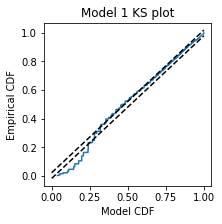

In [131]:
lambda1 = M1.predict(glmdata)
spikeindex = where(spikes)[0]  
Z = [sum(lambda1[a:b])  
    for a, b in zip(np.hstack((0, spikeindex[:-1])), spikeindex)]

eCDF = ECDF(Z)
mCDF = 1 - np.exp(-eCDF.x)  
nISI = len(Z)  

figure(figsize=(3, 3))
plot(mCDF, eCDF.y)  
plot([0,1], [0,1] + 1.36 / np.sqrt(nISI),'k--', ms = 2)  
plot([0,1], [0,1] - 1.36 / np.sqrt(nISI),'k--', ms = 2)

xlabel('Model CDF')
ylabel('Empirical CDF')
plt.title('Model 1 KS plot')
savefig('imgs/ks1.png')
show()


In [136]:
Dir = np.repeat(direction == 1, nTime)
glmdata['IDir'] = Dir  
M2 = smf.glm('spikes ~ IMove + IDir',  
    data=glmdata,
    family=Poisson()).fit()  
M2.summary()

print(np.exp(M2.params))


Intercept        0.048667
IMove[T.True]    1.410678
IDir[T.True]     0.601091
dtype: float64


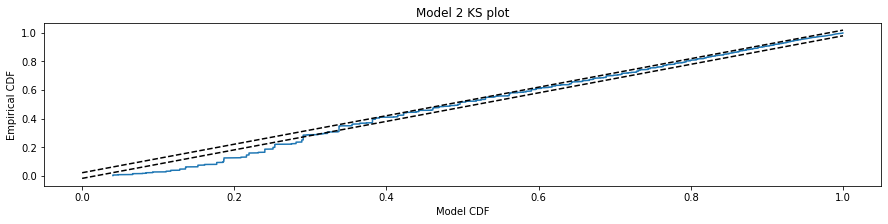

In [145]:
lambda2 = M2.predict(glmdata)  
spikeindex = where(glmdata.spikes)[0]

Z = [sum(lambda2[a:b]) 
    for a, b in zip(np.hstack((0, spikeindex[:-1])), spikeindex)] 

eCDF = ECDF(Z);  
mCDF = 1 - np.exp(-eCDF.x)  
N = len(Z)  

figure(figsize=(15,3))
plt.plot(mCDF, eCDF.y)  
plt.plot([0,1], [0,1] + 1.36 / np.sqrt(N),'k--', ms = 2)  
plt.plot([0,1], [0,1] - 1.36 / np.sqrt(N),'k--', ms = 2)


xlabel('Model CDF')
ylabel('Empirical CDF')
plt.title('Model 2 KS plot')
show()


In [153]:
ordK = 70
for k in range(1, ordK + 1):  
	glmdata['lag{:02d}'.format(k)] = np.roll(glmdata.spikes, k)  

glmdata['Time'] = np.tile(t, nTrial)

glmHist = glmdata.loc[lambda d: d['Time'] > t[ordK]]
glmHist.head()



formula = ('spikes ~' +  
       	'+'.join(glmHist.drop(columns='spikes').columns))  
M3 = smf.glm(formula,  
         	data=glmHist,  
         	family=Poisson()).fit()  
M3.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:                96450
Model:                            GLM   Df Residuals:                    96376
Model Family:                 Poisson   Df Model:                           73
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17967.
Date:                Tue, 26 Nov 2019   Deviance:                       26792.
Time:                        10:53:05   Pearson chi2:                 9.16e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.0622      0.046    -66.090      0.000      -3.153      -2.971
IMove[T.True]     0.3665      0.060      6.118      0.000       0.249       0.484
IDir[T.True]     -0.4989      0.034    -14.883      0.000      -0.565      -0.433
lag01            -1.5569      0.133    -11.664      0.000      -1.818      -1.295
lag02            -1.2337      0.115    -10.710      0.000      -1.459      -1.008
lag03            -0.4937      0.082     -5.993      0.000      -0.655      -0.332
lag04             0.0471      0.066      0.717      0.473      -0.082       0.176
lag05             0.3924      0.058      6.807      0.000       0.279       0.505
lag06             0.5639      0.055     10.324      0.000       0.457       0.671
lag07             0.4368      0.059      7.440      0.000       0.322       0.552
lag08             0.2545      0.064      3.998      0.000       0.130       0.379
lag09             0.0181      0.069      0.261      0.794      -0.118       0.154
lag10             0.0555      0.066      0.835      0.404      -0.075       0.186
lag11             0.0277      0.066      0.418      0.676      -0.102       0.157
lag12            -0.0009      0.067     -0.014      0.989      -0.132       0.130
lag13             0.0586      0.065      0.901      0.367      -0.069       0.186
lag14            -0.0416      0.069     -0.605      0.545      -0.176       0.093
lag15             0.0076      0.067      0.113      0.910      -0.124       0.139
lag16            -0.0748      0.070     -1.074      0.283      -0.211       0.062
lag17             0.0400      0.066      0.608      0.544      -0.089       0.169
lag18            -0.1212      0.071     -1.708      0.088      -0.260       0.018
lag19            -0.0658      0.069     -0.954      0.340      -0.201       0.069
lag20            -0.1430      0.072     -1.997      0.046      -0.283      -0.003
lag21            -0.1078      0.070     -1.533      0.125      -0.246       0.030
lag22             0.0056      0.067      0.084      0.933      -0.125       0.136
lag23            -0.0420      0.068     -0.614      0.539      -0.176       0.092
lag24            -0.1141      0.071     -1.598      0.110      -0.254       0.026
lag25            -0.0682      0.070     -0.977      0.329      -0.205       0.069
lag26            -0.1026      0.071     -1.444      0.149      -0.242       0.037
lag27            -0.0415      0.069     -0.602      0.547      -0.177       0.094
lag28             0.0555      0.066      0.843      0.399      -0.074       0.185
lag29             0.0178      0.067      0.265      0.791      -0.114       0.150
lag30            -0.0850      0.071     -1.200      0.230      -0.224       0.054
lag31            -0.0865      0.071     -1.222      0.222      -0.225       0.052
lag32            -0.0393      0.069     -0.571   

In [154]:
lagColumns = ' + '.join(glmHist.filter(like='lag', axis=1))
formula = 'spikes ~ IMove + IDir + IMove : ({0})'.format(lagColumns)
M4 = smf.glm(formula=formula, data=glmHist, family=Poisson()).fit()
M4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 spikes   No. Observations:                96450
Model:                            GLM   Df Residuals:                    96307
Model Family:                 Poisson   Df Model:                          142
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17889.
Date:                Tue, 26 Nov 2019   Deviance:                       26637.
Time:                        10:53:41   Pearson chi2:                 9.14e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.0339      0.053    -56.797      0.000      -3.139      -2.929
IMove[T.True]          0.3221      0.062      5.154      0.000       0.200       0.445
IDir[T.True]          -0.5012      0.034    -14.906      0.000      -0.567      -0.435
IMove[False]:lag01    -2.1004      0.303     -6.940      0.000      -2.694      -1.507
IMove[True]:lag01     -1.3948      0.149     -9.364      0.000      -1.687      -1.103
IMove[False]:lag02    -1.1973      0.194     -6.162      0.000      -1.578      -0.816
IMove[True]:lag02     -1.2779      0.143     -8.933      0.000      -1.558      -0.998
IMove[False]:lag03    -0.3466      0.131     -2.648      0.008      -0.603      -0.090
IMove[True]:lag03     -0.6043      0.106     -5.701      0.000      -0.812      -0.397
IMove[False]:lag04     0.0378      0.112      0.337      0.736      -0.182       0.257
IMove[True]:lag04      0.0271      0.081      0.334      0.738      -0.132       0.186
IMove[False]:lag05     0.2167      0.106      2.048      0.041       0.009       0.424
IMove[True]:lag05      0.4501      0.069      6.530      0.000       0.315       0.585
IMove[False]:lag06     0.4212      0.098      4.308      0.000       0.230       0.613
IMove[True]:lag06      0.6054      0.066      9.172      0.000       0.476       0.735
IMove[False]:lag07     0.3714      0.102      3.659      0.000       0.172       0.570
IMove[True]:lag07      0.4547      0.072      6.310      0.000       0.313       0.596
IMove[False]:lag08     0.1963      0.110      1.791      0.073      -0.018       0.411
IMove[True]:lag08      0.2716      0.078      3.471      0.001       0.118       0.425
IMove[False]:lag09     0.0774      0.115      0.676      0.499      -0.147       0.302
IMove[True]:lag09     -0.0261      0.087     -0.298      0.765      -0.197       0.145
IMove[False]:lag10     0.0594      0.114      0.519      0.604      -0.165       0.284
IMove[True]:lag10      0.0438      0.082      0.536      0.592      -0.116       0.204
IMove[False]:lag11    -0.0644      0.120     -0.535      0.592      -0.300       0.171
IMove[True]:lag11      0.0525      0.079      0.661      0.509      -0.103       0.208
IMove[False]:lag12    -0.0984      0.122     -0.808      0.419      -0.337       0.140
IMove[True]:lag12      0.0235      0.080      0.294      0.769      -0.133       0.180
IMove[False]:lag13     0.1273      0.110      1.161      0.246      -0.088       0.342
IMove[True]:lag13      0.0178      0.081      0.220      0.826      -0.141       0.176
IMove[False]:lag14     0.0200      0.117      0.171      0.864      -0.209       0.248
IMove[True]:lag14     -0.0673      0.085     -0.790      0.430      -0.234       0.100
IMove[False]:lag15     0.1307      0.111      1.181      0.238      -0.086       0.348
IMove[True]:lag15     -0.0581      0.0

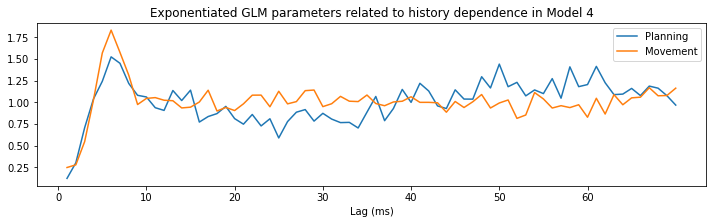

In [160]:
plot(range(1, ordK + 1),
 	np.exp(M4.params[3::2]),
 	label='Planning')  

plot(range(1, ordK+1),
 	np.exp(M4.params[4::2]),
 	label='Movement')  

plt.xticks(range(0, 70, 10))  
xlabel('Lag (ms)')
plt.legend()
plt.title('Exponentiated GLM parameters related to history dependence in Model 4')
show()


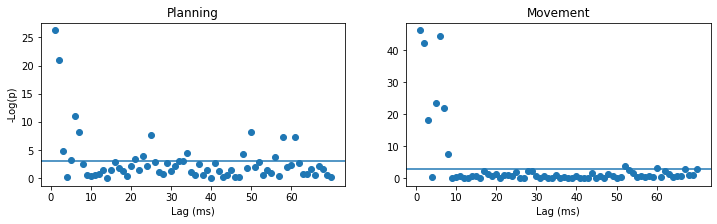

In [165]:
_, a = plt.subplots(1, 2)  
a[0].plot(range(1, ordK + 1),
      	-np.log(M4.pvalues[3::2]), 'o')  
a[0].axhline(3)  
a[0].set_xticks(range(0, 70, 10))  
a[0].set_xlabel('Lag (ms)')
a[0].set_ylabel('-Log(p)')
a[0].set_title('Planning')

a[1].plot(range(1, ordK + 1),
      	-np.log(M4.pvalues[4::2]), 'o')  
a[1].axhline(3)  
a[1].set_xticks(range(0, 70, 10))  
a[1].set_xlabel('Lag (ms)')
a[1].set_title('Movement')
show()




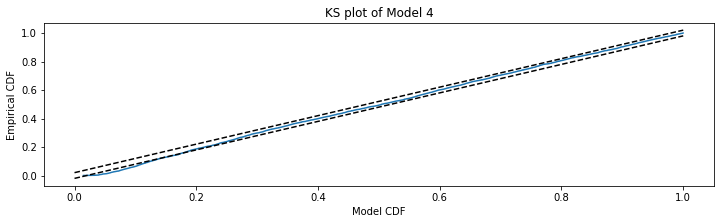

In [170]:
lambda4 = M4.predict(glmHist)  
spikeindex = where(glmHist.spikes)[0]  

Z = [sum(lambda4[a : b])  
 	for a,b in zip(np.hstack((0, spikeindex[:-1])), spikeindex)]  

eCDF = ECDF(Z)  
mCDF = 1 - np.exp(-eCDF.x)  
 
plt.plot(mCDF, eCDF.y)
N = len(spikeindex)
plot([0, 1], [0, 1] + 1.36 / np.sqrt(N), 'k--')
plt.plot([0, 1], [0, 1] - 1.36 / np.sqrt(N), 'k--')
xlabel('Model CDF')
ylabel('Empirical CDF')
plt.title('KS plot of Model 4')
show()


In [ ]:
maxord = 100  
for k in range(ordK + 1, maxord + 1):  
    glmdata['lag{:02d}'.format(k)] = np.roll(glmdata.spikes, k)

planHist = glmdata.loc[lambda d: d['Time'] < 0]  

formula = 'spikes ~ IDir'  
aic = np.zeros((maxord,))  

for k in range(maxord):  
    formula += ' + lag{:02d}'.format(k + 1)  
    M = smf.glm(formula=formula,  
        data=planHist,  
        family=Poisson()).fit()  
    aic[k] = M.aic

plt.plot(range(1, maxord + 1), aic)  
xlabel('Model Order')  
ylabel('AIC')
title('AIC plot of models with increasing number of\n' +
      'history-dependent components for planning period')
show()


In [ ]:
C = array([norm.pdf(arange(-5, ordK, 10), k, 5) for k in range(ordK)])
lags = glmdata.filter(like='lag').columns[:ordK]  
basisCols = glmdata.filter(items=lags).dot(C)  

for c in range(C.shape[-1]):  # Add the new basis columns to glmdata
    glmdata['b{}'.format(c)] = basisCols[c]

   
formula = 'spikes ~ IMove + IDir + IMove : ({})'.format(
    ' + '.join(glmdata.filter(like='b').columns))

glmHist = glmdata.loc[lambda d: d['Time'] > t[ordK]]
M5 = smf.glm(formula=formula,  
             data=glmHist,  
            family=Poisson()).fit()  
M5.summary()


In [ ]:
plot(range(1, ordK + 1),  
    exp(matmul(C, array(M5.params[3::2]))),
    label='Planning')
plot(range(1, ordK + 1),  
    exp(matmul(C, array(M5.params[4::2]))),
    label='Movement')

xlabel('Lag (ms)')  
ylabel('Modulation')
legend()
title('Exponential GLM parameters related to history dependence\n' +
        'using Gaussian kernel basis functions of Model 5')
show()


In [ ]:
lambda5 = M5.predict(glmHist)
spikeindex = where(glmHist.spikes)[0]

Z = [sum(lambda5[a : b])
    for a, b in zip(hstack((0, spikeindex[:-1])), spikeindex)]

eCDF = ECDF(Z)
mCDF = 1 - exp(-eCDF.x)

figure(figsize=(3, 3))
plot(mCDF, eCDF.y)
plot([0, 1], [0, 1] + 1.36 / sqrt(len(Z)), 'k--')
plot([0, 1], [0, 1] - 1.36 / sqrt(len(Z)), 'k--')
xlabel('Model CDF')
ylabel('Empirical CDF')
title('KS plot for Model 5')
show()


In [ ]:
print('Parameters:')
print(exp(M5.params[:3]))
print()
print('p-values:')
print(M5.pvalues[:3])


In [ ]:
plot(range(8), -log(M5.pvalues[3::2]), 'o', label="Planning")
plot(range(8), -log(M5.pvalues[4::2]), 'o', label="Movement")
axhline(3, c='k')
ylabel('-Log(p)')
xlabel('Lag parameter')
legend()
title('Negative log $p$-values for Model 5')
show()
